<a href="https://colab.research.google.com/github/EfthymiosCosta/Neural-Networks-Weight-Uncertainty/blob/main/BayesCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
!git clone https://github.com/kumar-shridhar/PyTorch-BayesianCNN.git

In [2]:
%cd BayesianCNN

/content/BayesianCNN


In [3]:
from __future__ import print_function

import os
import argparse

import torch
import numpy as np
from torch.optim import Adam, lr_scheduler
from torch.nn import functional as F

import data
import utils
import metrics
import config_bayesian as cfg
from BayesianCNN.models.BayesianModels.Bayesian3Conv3FC import BBB3Conv3FC
from BayesianCNN.models.BayesianModels.BayesianAlexNet import BBBAlexNet
from BayesianCNN.models.BayesianModels.BayesianLeNet import BBBLeNet

In [26]:
from layers.misc import ModuleWrapper, FlattenLayer
from layers.BBB.BBBConv import BBBConv2d
from layers.BBB.BBBLinear import BBBLinear
import torch.nn as nn

In [35]:
# CUDA settings
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def getModel(net_type, inputs, outputs, priors, layer_type, activation_type):
    if (net_type == 'lenet'):
        return BBBLeNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == 'alexnet'):
        return BBBAlexNet(outputs, inputs, priors, layer_type, activation_type)
    elif (net_type == '3conv3fc'):
        return BBB3Conv3FC(outputs, inputs, priors, layer_type, activation_type)
    else:
        raise ValueError('Network should be either [LeNet / AlexNet / 3Conv3FC')

In [30]:
def train_model(net, optimizer, criterion, trainloader, num_ens=1, beta_type=0.1, epoch=None, num_epochs=None):
    net.train()
    training_loss = 0.0
    accs = []
    kl_list = []
    for i, (inputs, labels) in enumerate(trainloader, 1):

        optimizer.zero_grad()

        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)

        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1)
        
        kl = kl / num_ens
        kl_list.append(kl.item())
        log_outputs = utils.logmeanexp(outputs, dim=2)

        beta = metrics.get_beta(i-1, len(trainloader), beta_type, epoch, num_epochs)
        loss = criterion(log_outputs, labels, kl, beta)
        loss.backward()
        optimizer.step()

        accs.append(metrics.acc(log_outputs.data, labels))
        training_loss += loss.cpu().data.numpy()
    return training_loss/len(trainloader), np.mean(accs), np.mean(kl_list)


In [31]:
def validate_model(net, criterion, validloader, num_ens=1, beta_type=0.1, epoch=None, num_epochs=None):
    """Calculate ensemble accuracy and NLL Loss"""
    net.train()
    valid_loss = 0.0
    accs = []

    for i, (inputs, labels) in enumerate(validloader):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = torch.zeros(inputs.shape[0], net.num_classes, num_ens).to(device)
        kl = 0.0
        for j in range(num_ens):
            net_out, _kl = net(inputs)
            kl += _kl
            outputs[:, :, j] = F.log_softmax(net_out, dim=1).data

        log_outputs = utils.logmeanexp(outputs, dim=2)

        beta = metrics.get_beta(i-1, len(validloader), beta_type, epoch, num_epochs)
        valid_loss += criterion(log_outputs, labels, kl, beta).item()
        accs.append(metrics.acc(log_outputs, labels))

    return valid_loss/len(validloader), np.mean(accs)


In [50]:
def getDataloader(trainset, testset, batch_size, num_workers):
    num_train = len(trainset)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle = True, num_workers=num_workers)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
        num_workers=num_workers)

    return train_loader, test_loader

In [57]:
def run(dataset, net_type):

    ELBO = []
    train_acc_tracker = []
    val_acc_tracker = []
    # Hyper Parameter settings
    layer_type = cfg.layer_type
    activation_type = cfg.activation_type
    priors = cfg.priors

    train_ens = cfg.train_ens
    valid_ens = cfg.valid_ens
    n_epochs = 200
    lr_start = cfg.lr_start
    # set to 0 cos otherwise sometimes get assertion error: can only test a child process
    num_workers = 0
    valid_size = 0.001
    batch_size = cfg.batch_size
    beta_type = cfg.beta_type

    trainset, testset, inputs, outputs = data.getDataset(dataset)
    train_loader, test_loader = getDataloader(
        trainset, testset, batch_size, num_workers)
    net = getModel(net_type, inputs, outputs, priors, layer_type, activation_type).to(device)

    ckpt_dir = f'checkpoints/{dataset}/bayesian'
    ckpt_name = f'checkpoints/{dataset}/bayesian/model_{net_type}_{layer_type}_{activation_type}.pt'

    if not os.path.exists(ckpt_dir):
        os.makedirs(ckpt_dir, exist_ok=True)

    criterion = metrics.ELBO(len(trainset)).to(device)
    optimizer = Adam(net.parameters(), lr=lr_start)
    lr_sched = lr_scheduler.ReduceLROnPlateau(optimizer, patience=6, verbose=True)
    valid_loss_max = np.Inf
    for epoch in range(n_epochs):  # loop over the dataset multiple times

        train_loss, train_acc, train_kl = train_model(net, optimizer, criterion, train_loader, num_ens=train_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)
        # changed valid LOSS TO TEST LOSS!!!
        valid_loss, valid_acc = validate_model(net, criterion, test_loader, num_ens=valid_ens, beta_type=beta_type, epoch=epoch, num_epochs=n_epochs)
        lr_sched.step(valid_loss)

        ELBO += [train_loss]
        train_acc_tracker += [train_acc]
        val_acc_tracker += [valid_acc]

        print('Epoch: {} \tTraining Loss: {:.4f} \tTraining Accuracy: {:.4f} \tValidation Loss: {:.4f} \tValidation Accuracy: {:.4f} \ttrain_kl_div: {:.4f}'.format(
            epoch, train_loss, train_acc, valid_loss, valid_acc, train_kl))

        # save model if validation accuracy has increased
        if valid_loss <= valid_loss_max:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
                valid_loss_max, valid_loss))
            torch.save(net.state_dict(), ckpt_name)
            valid_loss_max = valid_loss
    return ELBO, train_acc_tracker, val_acc_tracker

In [55]:
dataset = 'MNIST'
net_type = 'lenet'

In [58]:
ELBO, train_acc, test_acc = run(dataset, net_type)

Epoch: 0 	Training Loss: 863849.4660 	Training Accuracy: 0.4624 	Validation Loss: 546478.8328 	Validation Accuracy: 0.8514 	train_kl_div: 7738365.7043
Validation loss decreased (inf --> 546478.832812).  Saving model ...
Epoch: 1 	Training Loss: 449726.1745 	Training Accuracy: 0.8973 	Validation Loss: 373479.2539 	Validation Accuracy: 0.9243 	train_kl_div: 4294934.1872
Validation loss decreased (546478.832812 --> 373479.253906).  Saving model ...
Epoch: 2 	Training Loss: 323325.0786 	Training Accuracy: 0.9307 	Validation Loss: 276991.3578 	Validation Accuracy: 0.9514 	train_kl_div: 3094733.2351
Validation loss decreased (373479.253906 --> 276991.357812).  Saving model ...
Epoch: 3 	Training Loss: 245212.4936 	Training Accuracy: 0.9480 	Validation Loss: 214198.8652 	Validation Accuracy: 0.9581 	train_kl_div: 2347956.9495
Validation loss decreased (276991.357812 --> 214198.865234).  Saving model ...
Epoch: 4 	Training Loss: 192346.3494 	Training Accuracy: 0.9549 	Validation Loss: 171190.3

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 71 	Training Loss: 4246.6791 	Training Accuracy: 0.9902 	Validation Loss: 5293.0136 	Validation Accuracy: 0.9850 	train_kl_div: 23630.2118
Epoch: 72 	Training Loss: 4169.1652 	Training Accuracy: 0.9907 	Validation Loss: 5468.9588 	Validation Accuracy: 0.9858 	train_kl_div: 23624.1475
Epoch: 73 	Training Loss: 4221.0554 	Training Accuracy: 0.9906 	Validation Loss: 5327.8705 	Validation Accuracy: 0.9861 	train_kl_div: 23617.0051


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 74 	Training Loss: 4274.3699 	Training Accuracy: 0.9902 	Validation Loss: 5237.4375 	Validation Accuracy: 0.9876 	train_kl_div: 23610.8296


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 75 	Training Loss: 4206.2453 	Training Accuracy: 0.9905 	Validation Loss: 5283.9434 	Validation Accuracy: 0.9863 	train_kl_div: 23604.0426


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 76 	Training Loss: 4129.0919 	Training Accuracy: 0.9908 	Validation Loss: 5183.2296 	Validation Accuracy: 0.9858 	train_kl_div: 23596.9844


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch    78: reducing learning rate of group 0 to 1.0000e-06.
Epoch: 77 	Training Loss: 4227.1355 	Training Accuracy: 0.9902 	Validation Loss: 5635.8038 	Validation Accuracy: 0.9859 	train_kl_div: 23590.3351


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    self._shutdown_workers()
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 78 	Training Loss: 4177.9565 	Training Accuracy: 0.9903 	Validation Loss: 5215.8106 	Validation Accuracy: 0.9856 	train_kl_div: 23587.0993


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    if w.is_alive():
    self._shutdown_workers()
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child

Epoch: 79 	Training Loss: 4229.0388 	Training Accuracy: 0.9906 	Validation Loss: 5505.5276 	Validation Accuracy: 0.9852 	train_kl_div: 23586.4398


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
    if w.is_alive():
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 80 	Training Loss: 4165.9278 	Training Accuracy: 0.9904 	Validation Loss: 4973.6767 	Validation Accuracy: 0.9870 	train_kl_div: 23585.7249
Validation loss decreased (5097.635040 --> 4973.676697).  Saving model ...


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 81 	Training Loss: 4203.7125 	Training Accuracy: 0.9910 	Validation Loss: 5716.6169 	Validation Accuracy: 0.9835 	train_kl_div: 23585.1264


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Traceback (most recent call last):
AssertionError: can only test a child process
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 82 	Training Loss: 4219.2637 	Training Accuracy: 0.9901 	Validation Loss: 5375.5309 	Validation Accuracy: 0.9863 	train_kl_div: 23584.4574


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
    if w.is_alive():
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

Epoch: 83 	Training Loss: 4120.5411 	Training Accuracy: 0.9906 	Validation Loss: 5302.7652 	Validation Accuracy: 0.9860 	train_kl_div: 23583.7820


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fc2bd463290>
AssertionError: can only test a child process
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

Epoch: 84 	Training Loss: 4222.7927 	Training Accuracy: 0.9905 	Validation Loss: 5252.2748 	Validation Accuracy: 0.9859 	train_kl_div: 23583.2059
Epoch: 85 	Training Loss: 4234.5921 	Training Accuracy: 0.9901 	Validation Loss: 5280.7486 	Validation Accuracy: 0.9864 	train_kl_div: 23582.6483
Epoch: 86 	Training Loss: 4195.0163 	Training Accuracy: 0.9902 	Validation Loss: 5428.1092 	Validation Accuracy: 0.9859 	train_kl_div: 23581.9723
Epoch    88: reducing learning rate of group 0 to 1.0000e-07.
Epoch: 87 	Training Loss: 4135.0442 	Training Accuracy: 0.9912 	Validation Loss: 5247.3477 	Validation Accuracy: 0.9861 	train_kl_div: 23581.2438
Epoch: 88 	Training Loss: 4193.8434 	Training Accuracy: 0.9906 	Validation Loss: 5622.1333 	Validation Accuracy: 0.9849 	train_kl_div: 23580.8368
Epoch: 89 	Training Loss: 4263.4675 	Training Accuracy: 0.9896 	Validation Loss: 5272.4618 	Validation Accuracy: 0.9843 	train_kl_div: 23580.8399
Epoch: 90 	Training Loss: 4171.3965 	Training Accuracy: 0.9907

In [59]:
import matplotlib.pyplot as plt

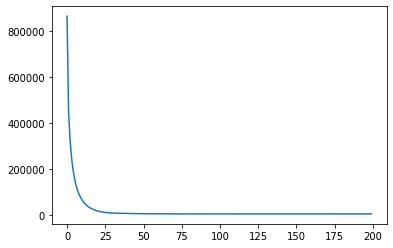

In [60]:
plt.plot(range(200), ELBO)

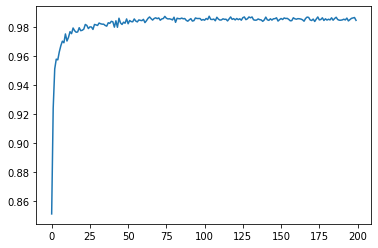

In [61]:
plt.plot(range(200), test_acc)

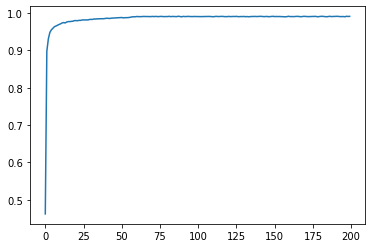

In [62]:
plt.plot(range(200), train_acc)

In [ ]:
ELBO, train_acc, test_acc

In [ ]:
%cd /content

In [87]:
from google.colab import drive
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/'
PATH = 'gdrive/MyDrive/Colab Notebooks/Project_StatML_Module2/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [66]:
import pickle

In [88]:
with open(PATH + "LeNET_ELBO_evolution.pickle", 'wb') as f:
    pickle.dump(ELBO, f)

In [89]:
with open(PATH + "LeNET_train_acc_evolution.pickle", 'wb') as f:
    pickle.dump(train_acc, f)

In [91]:
with open(PATH + "LeNET_test_acc_evolution.pickle", 'wb') as f:
    pickle.dump(test_acc, f)

In [ ]:
plt.plot(range(200), test_acc)
plt.lines()

In [114]:
plt.style.use('seaborn-whitegrid')
from matplotlib.ticker import PercentFormatter

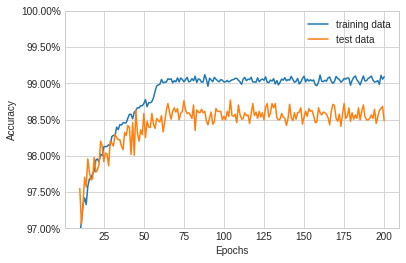

In [126]:
fig = plt.figure()
ax = plt.axes()

ax.plot(range(10, 201), train_acc[9:], label = 'training data');
ax.plot(range(10, 201), test_acc[9:], label = 'test data');
plt.ylim(0.97, 1);
# plt.axis('tight');
plt.xlabel("Epochs")
plt.ylabel("Accuracy");
plt.legend();
#ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.yaxis.set_major_formatter(PercentFormatter(1.0, 2)) 

plt.savefig('Bayesian_LeNet_Accuracy_during_training.png', bbox_inches='tight', dpi=1200)